In [6]:
import pandas as pd

# Especifica la ruta del archivo CSV
file_path = 'df_mora_prestamos2.csv'

# Cargar el CSV en un DataFrame
df_mora_prestamos = pd.read_csv(file_path)

In [2]:
import pandas as pd

# Supongamos que df_mora_prestamos es tu DataFrame
# Si no has cargado el DataFrame, puedes hacerlo de la siguiente manera:
# df_mora_prestamos = pd.read_csv('tu_archivo.csv')

# Contar la cantidad de registros y variables
num_registros = df_mora_prestamos.shape[0]  # Número de filas
num_variables = df_mora_prestamos.shape[1]  # Número de columnas

# Imprimir los resultados
print(f"Cantidad de registros: {num_registros}")
print(f"Cantidad de variables: {num_variables}")

Cantidad de registros: 1622022
Cantidad de variables: 35


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar dataset
df_mora_prestamos = pd.read_csv('df_mora_prestamos2.csv')

# Separar características y variable objetivo
X = df_mora_prestamos.drop('Morosidad', axis=1)
y = df_mora_prestamos['Morosidad']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Configurar el modelo con parámetros aleatorios
base_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_proba):
    return {
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred)
    }

# Lista para almacenar resultados
results = []

# 1. Sin balanceo
print("Entrenando modelo sin balanceo...")
model_no_balance = base_model.fit(X_train, y_train)
y_pred = model_no_balance.predict(X_test)
y_pred_proba = model_no_balance.predict_proba(X_test)[:, 1]
results.append(('Sin Balanceo', evaluate_model(y_test, y_pred, y_pred_proba)))

# 2. SMOTE
print("Entrenando modelo con SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
model_smote = base_model.fit(X_train_smote, y_train_smote)
y_pred = model_smote.predict(X_test)
y_pred_proba = model_smote.predict_proba(X_test)[:, 1]
results.append(('SMOTE', evaluate_model(y_test, y_pred, y_pred_proba)))

# 3. SMOTE-Tomek
print("Entrenando modelo con SMOTE-Tomek...")
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
model_smote_tomek = base_model.fit(X_train_smote_tomek, y_train_smote_tomek)
y_pred = model_smote_tomek.predict(X_test)
y_pred_proba = model_smote_tomek.predict_proba(X_test)[:, 1]
results.append(('SMOTE-Tomek', evaluate_model(y_test, y_pred, y_pred_proba)))

# Crear DataFrame con resultados
df_results = pd.DataFrame([
    {**{'Técnica': name}, **metrics}
    for name, metrics in results
])
df_results = df_results.set_index('Técnica').round(4)

# Crear tabla estilizada
def highlight_max_min(data):
    is_max = data == data.max()
    is_min = data == data.min()
    return ['background-color: #90EE90' if v else 'background-color: #FFB6C1' if m else '' 
            for v, m in zip(is_max, is_min)]

styled_df = df_results.style\
    .apply(highlight_max_min)\
    .format('{:.4f}')

# Mostrar resultados
print("\nComparativa de Técnicas de Balanceo:")
print(df_results)

# Guardar resultados estilizados en HTML
styled_df.to_html('resultados_xgboost.html')

# Guardar resultados en CSV
df_results.to_csv('resultados_xgboost.csv')

Entrenando modelo sin balanceo...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:51:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Entrenando modelo con SMOTE...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:51:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Entrenando modelo con SMOTE-Tomek...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:54:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Comparativa de Técnicas de Balanceo:
              roc_auc  precision  recall      f1  accuracy
Técnica                                                   
Sin Balanceo   0.9990     0.9747  0.9532  0.9638    0.9959
SMOTE          0.9987     0.8948  0.9762  0.9338    0.9921
SMOTE-Tomek    0.9987     0.8957  0.9762  0.9342    0.9922


MEJORES HIPERPARARAMETROS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Cargar dataset
df_mora_prestamos = pd.read_csv('df_mora_prestamos2.csv')

# Separar características y variable objetivo
X = df_mora_prestamos.drop('Morosidad', axis=1)
y = df_mora_prestamos['Morosidad']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Definir el espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Configurar el modelo base
model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Realizar la búsqueda
print("Iniciando búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y score
print("\nMejores parámetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nMejor score (ROC-AUC): {random_search.best_score_:.4f}")

# Entrenar el modelo con los mejores parámetros
best_model = xgb.XGBClassifier(**random_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular métricas
print("\nMétricas en conjunto de prueba:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Guardar los mejores parámetros
pd.DataFrame([random_search.best_params_]).to_csv('mejores_parametros_xgboost.csv', index=False)

Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:00:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:00:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:00:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


Mejores parámetros encontrados:
subsample: 0.9
reg_lambda: 0.1
reg_alpha: 1.0
n_estimators: 600
min_child_weight: 5
max_depth: 10
learning_rate: 0.1
gamma: 0
colsample_bytree: 0.6

Mejor score (ROC-AUC): 0.9998

Métricas en conjunto de prueba:
ROC-AUC: 0.9998
Precision: 0.9906
Recall: 0.9782
F1-Score: 0.9843
Accuracy: 0.9982


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Cargar dataset
df_mora_prestamos = pd.read_csv('df_mora_prestamos2.csv')

# Separar características y variable objetivo
X = df_mora_prestamos.drop('Morosidad', axis=1)
y = df_mora_prestamos['Morosidad']

# Mejores hiperparámetros encontrados
best_params = {
    'subsample': 0.9,
    'reg_lambda': 0.1,
    'reg_alpha': 1.0,
    'n_estimators': 600,
    'min_child_weight': 5,
    'max_depth': 10,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'random_state': 42,
    'use_label_encoder': False
}

# Preparar KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listas para almacenar resultados
train_scores = []
val_scores = []

print(f"Iniciando validación cruzada con {n_splits} folds...")

# Realizar validación cruzada
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}/{n_splits}")
    
    # Dividir datos
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Crear y entrenar modelo
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Predicciones
    train_pred = model.predict(X_train)
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    val_pred = model.predict(X_val)
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calcular métricas
    train_metrics = {
        'roc_auc': roc_auc_score(y_train, train_pred_proba),
        'precision': precision_score(y_train, train_pred),
        'recall': recall_score(y_train, train_pred),
        'f1': f1_score(y_train, train_pred),
        'accuracy': accuracy_score(y_train, train_pred)
    }
    
    val_metrics = {
        'roc_auc': roc_auc_score(y_val, val_pred_proba),
        'precision': precision_score(y_val, val_pred),
        'recall': recall_score(y_val, val_pred),
        'f1': f1_score(y_val, val_pred),
        'accuracy': accuracy_score(y_val, val_pred)
    }
    
    train_scores.append(train_metrics)
    val_scores.append(val_metrics)
    
    print("\nMétricas de entrenamiento:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nMétricas de validación:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")

# Calcular promedios y desviaciones estándar
train_means = pd.DataFrame(train_scores).mean()
train_stds = pd.DataFrame(train_scores).std()
val_means = pd.DataFrame(val_scores).mean()
val_stds = pd.DataFrame(val_scores).std()

# Crear DataFrame para el resumen
summary_data = {
    'Train Mean': train_means,
    'Train Std': train_stds,
    'Val Mean': val_means,
    'Val Std': val_stds,
    'Diff (Train-Val)': train_means - val_means
}

summary_df = pd.DataFrame(summary_data).round(4)

print("\nResumen de validación cruzada:")
print(summary_df)

# Guardar resultados
summary_df.to_csv('xgboost_cross_validation_results.csv')

# Evaluar overfitting
print("\nEvaluación de overfitting:")
for metric in train_means.index:
    diff = train_means[metric] - val_means[metric]
    print(f"\n{metric}:")
    print(f"Diferencia Train-Val: {abs(diff):.4f}")
    if abs(diff) > 0.02:
        print("⚠️ Posible overfitting detectado")
    else:
        print("✓ No hay evidencia de overfitting")

Iniciando validación cruzada con 5 folds...

Fold 1/5


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:18:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Métricas de entrenamiento:
roc_auc: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
accuracy: 1.0000

Métricas de validación:
roc_auc: 0.9998
precision: 0.9920
recall: 0.9798
f1: 0.9858
accuracy: 0.9984

Fold 2/5


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:53:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Métricas de entrenamiento:
roc_auc: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
accuracy: 1.0000

Métricas de validación:
roc_auc: 0.9998
precision: 0.9925
recall: 0.9798
f1: 0.9861
accuracy: 0.9984

Fold 3/5


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Métricas de entrenamiento:
roc_auc: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
accuracy: 1.0000

Métricas de validación:
roc_auc: 0.9998
precision: 0.9917
recall: 0.9783
f1: 0.9849
accuracy: 0.9983

Fold 4/5


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Métricas de entrenamiento:
roc_auc: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
accuracy: 1.0000

Métricas de validación:
roc_auc: 0.9998
precision: 0.9913
recall: 0.9782
f1: 0.9847
accuracy: 0.9983

Fold 5/5


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:40:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Métricas de entrenamiento:
roc_auc: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
accuracy: 1.0000

Métricas de validación:
roc_auc: 0.9998
precision: 0.9906
recall: 0.9783
f1: 0.9844
accuracy: 0.9982

Resumen de validación cruzada:
           Train Mean  Train Std  Val Mean  Val Std  Diff (Train-Val)
roc_auc           1.0        0.0    0.9998   0.0000            0.0002
precision         1.0        0.0    0.9916   0.0007            0.0084
recall            1.0        0.0    0.9789   0.0008            0.0211
f1                1.0        0.0    0.9852   0.0007            0.0148
accuracy          1.0        0.0    0.9983   0.0001            0.0017

Evaluación de overfitting:

roc_auc:
Diferencia Train-Val: 0.0002
✓ No hay evidencia de overfitting

precision:
Diferencia Train-Val: 0.0084
✓ No hay evidencia de overfitting

recall:
Diferencia Train-Val: 0.0211
⚠️ Posible overfitting detectado

f1:
Diferencia Train-Val: 0.0148
✓ No hay evidencia de overfitting

accuracy:
Diferencia Trai

Entrenando modelo XGBoost con los mejores hiperparámetros...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:45:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Comparación de Métricas entre Dataset Prueba (Original) y Dataset Real:
     Métrica  Dataset Prueba (Original)  Dataset Real  Desvío
0   Accuracy                     0.9982        0.9934  0.0048
1  Precision                     0.9906        0.9246  0.0660
2     Recall                     0.9782        0.9874  0.0092
3   F1-Score                     0.9843        0.9550  0.0293
4    ROC-AUC                     0.9998        0.9997  0.0001


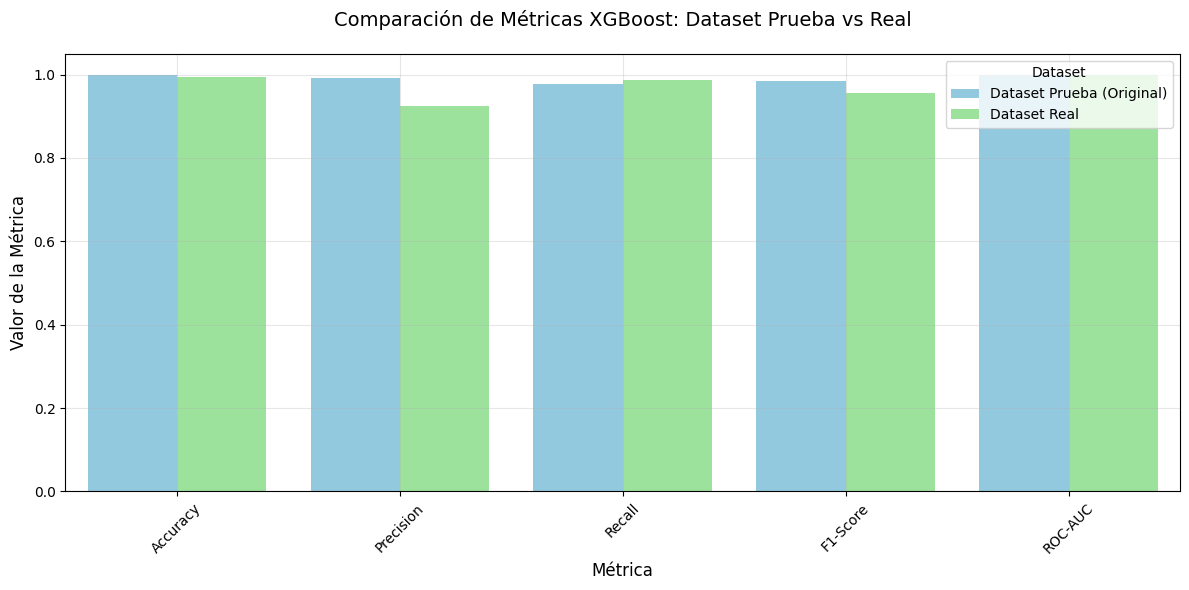

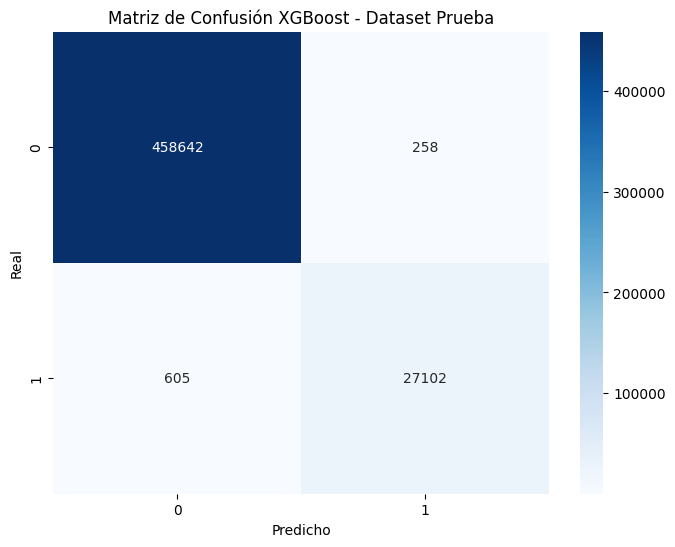

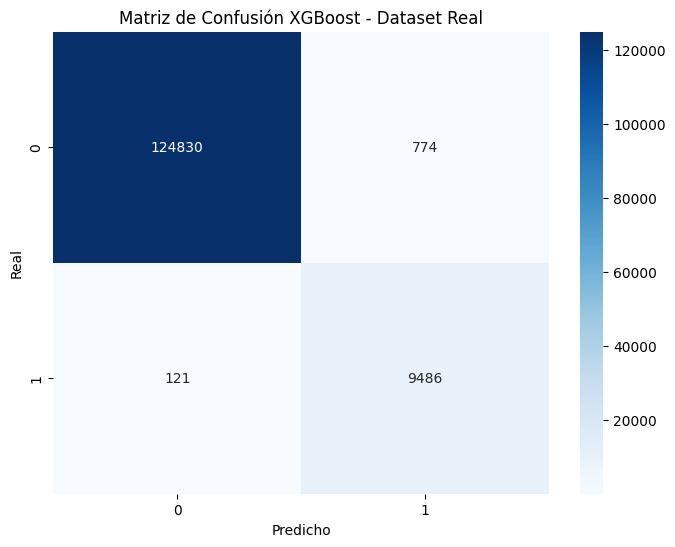


Distribución de clases en los datasets:

Dataset Original:
Morosidad
0    0.9431
1    0.0569
Name: proportion, dtype: float64

Dataset Nuevo:
Morosidad
0    0.9289
1    0.0711
Name: proportion, dtype: float64


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# Función para calcular métricas
def calcular_metricas(modelo, X, y):
    y_pred = modelo.predict(X)
    y_pred_proba = modelo.predict_proba(X)[:, 1]
    
    roc_auc = roc_auc_score(y, y_pred_proba)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    
    return {
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'ROC-AUC': round(roc_auc, 4)
    }

# Cargar datasets
df_mora_prestamos_original = pd.read_csv('df_mora_prestamos2.csv')
nuevo_dataset = pd.read_csv('df_mora_prestamos_202401.csv')

# Separar características y variable objetivo
X_original = df_mora_prestamos_original.drop('Morosidad', axis=1)
y_original = df_mora_prestamos_original['Morosidad']
X_nuevo = nuevo_dataset.drop('Morosidad', axis=1)
y_nuevo = nuevo_dataset['Morosidad']

# Asegurar nombres consistentes
X_original.columns = X_original.columns.str.replace(' ', '_')
X_nuevo.columns = X_nuevo.columns.str.replace(' ', '_')

# Dividir datos del dataset original
X_train, X_test, y_train, y_test = train_test_split(
    X_original, y_original, test_size=0.3, stratify=y_original, random_state=42
)

# Configurar modelo con los mejores hiperparámetros
best_params = {
    'subsample': 0.9,
    'reg_lambda': 0.1,
    'reg_alpha': 1.0,
    'n_estimators': 600,
    'min_child_weight': 5,
    'max_depth': 10,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'random_state': 42,
    'use_label_encoder': False
}

# Entrenar modelo
print("Entrenando modelo XGBoost con los mejores hiperparámetros...")
modelo = xgb.XGBClassifier(**best_params)
modelo.fit(X_train, y_train)

# Calcular métricas en conjunto de prueba original
metricas_test = calcular_metricas(modelo, X_test, y_test)

# Calcular métricas en nuevo dataset
metricas_nuevo = calcular_metricas(modelo, X_nuevo, y_nuevo)

# Comparar métricas
comparacion_metricas = pd.DataFrame({
    'Métrica': list(metricas_test.keys()),
    'Dataset Prueba (Original)': list(metricas_test.values()),
    'Dataset Real': list(metricas_nuevo.values()),
    'Desvío': [
        round(abs(metricas_test[m] - metricas_nuevo[m]), 4) for m in metricas_test
    ]
})

# Mostrar resultados
print("\nComparación de Métricas entre Dataset Prueba (Original) y Dataset Real:")
print(comparacion_metricas)

# Visualizar comparación
plt.figure(figsize=(12, 6))
sns.barplot(
    data=comparacion_metricas.melt(id_vars='Métrica', 
                                  value_vars=['Dataset Prueba (Original)', 'Dataset Real']),
    x='Métrica', 
    y='value', 
    hue='variable',
    palette=['skyblue', 'lightgreen']
)

plt.title("Comparación de Métricas XGBoost: Dataset Prueba vs Real", fontsize=14, pad=20)
plt.ylabel("Valor de la Métrica", fontsize=12)
plt.xlabel("Métrica", fontsize=12)
plt.legend(title="Dataset", title_fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('xgboost_metrics_comparison.png')
plt.show()

# Matriz de confusión para conjunto de prueba
cm_test = confusion_matrix(y_test, modelo.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión XGBoost - Dataset Prueba')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.savefig('xgboost_confusion_matrix_test.png')
plt.show()

# Matriz de confusión para nuevo dataset
cm_nuevo = confusion_matrix(y_nuevo, modelo.predict(X_nuevo))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nuevo, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión XGBoost - Dataset Real')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.savefig('xgboost_confusion_matrix_real.png')
plt.show()

# Guardar resultados en CSV
comparacion_metricas.to_csv('xgboost_comparison_results.csv', index=False)

# Mostrar distribución de clases en ambos datasets
print("\nDistribución de clases en los datasets:")
print("\nDataset Original:")
print(y_original.value_counts(normalize=True).round(4))
print("\nDataset Nuevo:")
print(y_nuevo.value_counts(normalize=True).round(4))